In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from alertstack.analyse import Analyse
from alertstack.scramble_catalogues.blazar_catalogue import Fermi4FGLBlazarCatalogue, AverageFluxWeightHypothesis
from alertstack.fixed_catalogues.icecube_neutrino_alerts import HealpixNeutrinoAlertCatalogue
from alertstack.stats import GammaDistribution
from examples.fermi_neutrino_alert import blazar_analysis

In [2]:
blazars = Fermi4FGLBlazarCatalogue()

blazars.data = blazars.data
# # print(blazars.data["Flux1000"][:5])
# nu_cat = CircularisedNeutrinoAlertCatalogue()
# nu_cat.data = nu_cat.data

# print(len(nu_cat.data))

# ana = Analyse(
#     blazars,
#     [AverageFluxWeightHypothesis],
#     nu_cat,
#     blazar_cache
# )

In [3]:
print(blazars.data)

[(b'4FGL J2253.9+1609 ', 343.4963,  16.1506,  86.11852, -38.18486 , 0.00456378, 0.00456378, -53.83, 0.0074, 0.0074, -53.83,  699, b'                  ', 443.8451  ,   517.46234, 9.8347442e-08, 5.9637822e-10, 1.1148474e-09, 5.3422553e-12, b'PLSuperExpCutoff ', 6.32308927e-10, 2.8152322e-12, 2.3871574, 0.00337629, 7.2006756e-10, 3.9487983e-12, 2.3148952 , 0.00499897, 0.09993269, 0.00273778, 38.145714 , 7.01410541e-10, 3.5839014e-12, 2.0142322e+00, 0.00954529, 0.01990755, 0.00142085, 0.5183553, 0.00666065, 39.507847 , 7.2486000e+04, [2.52024142e-06, 1.60860168e-06, 4.44110952e-07, 8.31356104e-08, 1.40801300e-08, 1.10932763e-09, 6.31789135e-11], [[-9.98927945e-08,  9.98927945e-08], [-2.20194778e-08,  2.20194778e-08], [-3.12940207e-09,  3.12940207e-09], [-7.09020287e-10,  7.09020287e-10], [-2.33759068e-10,  2.33759068e-10], [-6.05853215e-11,  6.05853215e-11], [-1.34684000e-11,  1.54910147e-11]], [4.02013783e-10, 3.80391274e-10, 2.94930386e-10, 1.90219215e-10, 8.72911535e-11, 2.30096723e-11,

In [4]:
best_ra = 167.43
best_dec = -22.39

min_ra = 167.43 - 2.63
max_ra = 167.43 + 3.40 

min_dec = -22.39 - 2.89
max_dec = -22.39 + 2.88

def dist(ra, dec):
    return ((best_ra - ra)**2 + (best_dec - dec)**2)**0.5

for blazar in blazars.data:
#     if blazar["ra_rad"] > min_ra:
#         print(blazar["ra_rad"], blazar["ra_rad"] > min_ra)
    if np.logical_and(blazar["ra_rad"] > min_ra, blazar["ra_rad"] < max_ra):
#         print(blazar["dec_rad"], min_dec, max_dec)
        if np.logical_and(blazar["dec_rad"] > min_dec, blazar["dec_rad"] < max_dec):
            print(blazar["Source_Name"], blazar["ra_rad"], blazar["dec_rad"], dist(blazar["ra_rad"], blazar["dec_rad"]), blazar["TEVCAT_FLAG"], blazar['ASSOC_TEV'])

b'4FGL J1103.6-2329 ' 165.9091 -23.4957 1.8803459327021894 b'P' b'1ES 1101-232              '


In [5]:
all_res = blazar_analysis.iterate_run(n_trials=100, injection_hypo=AverageFluxWeightHypothesis, fraction=0.5, nsteps=10)

all_res = blazar_analysis.load_results()
    # input("?")

100%|██████████| 100/100 [00:01<00:00, 73.62it/s]


Saving to: /Users/robertstein/Code/alertstack/examples/fermi_neutrino_alert/cache/None.pkl
dict_keys([0.0, 0.05, 0.1, 0.15000000000000002, 0.2, 0.25, 0.30000000000000004, 0.35000000000000003, 0.4, 0.45, 0.5])
Saving to: /Users/robertstein/Code/alertstack/examples/fermi_neutrino_alert/cache/None.pkl
dict_keys([0.0, 0.05, 0.1, 0.15000000000000002, 0.2, 0.25, 0.30000000000000004, 0.35000000000000003, 0.4, 0.45, 0.5])
      fun: nan
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 693.30590975, 4777.47918239, 2341.07287724])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 292
      nit: 20
   status: 2
  success: False
        x: array([ 2.37581644, -0.1257252 ,  0.13818016])


In [6]:
sens_threshold = dict()
disc_3_threshold = dict()
disc_4_threshold = dict()
disc_5_threshold = dict()
disc_6_threshold = dict()

zero_key = 0.0

for key, val in all_res[zero_key].items():
    sens_threshold[key] = np.median(val)
    gd = GammaDistribution(val)
    disc_3_threshold[key] = gd.calculate_discovery_potential(3.)
    disc_4_threshold[key] = gd.calculate_discovery_potential(4.)
    disc_5_threshold[key] = gd.calculate_discovery_potential(5.)
    disc_6_threshold[key] = gd.calculate_discovery_potential(6.)
    # print(Chi2(val))

      fun: nan
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 693.30590975, 4777.47918239, 2341.07287724])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 292
      nit: 20
   status: 2
  success: False
        x: array([ 2.37581644, -0.1257252 ,  0.13818016])


      fun: nan
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 693.30590975, 4777.47918239, 2341.07287724])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 292
      nit: 20
   status: 2
  success: False
        x: array([ 2.37581644, -0.1257252 ,  0.13818016])


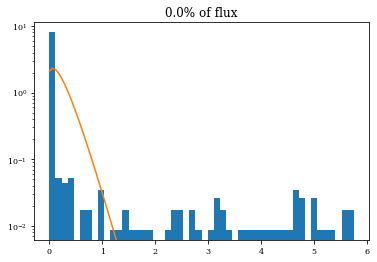

3 Sigma Discovery Potential: 0.8747440474850754
0.9892865235584912
4 Sigma Discovery Potential: 1.473269970888121
0.9997486409378323
5 Sigma Discovery Potential: 2.1888651067279286
0.9999977249875244
6 Sigma Discovery Potential: 3.0285114643841458
0.9999999921699388
      fun: -241.4607406718875
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.70530257e-05, -6.49215542e+03, -2.84217094e-06])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 388
      nit: 43
   status: 0
  success: True
        x: array([ 0.23907741, -0.01      ,  0.26584526])


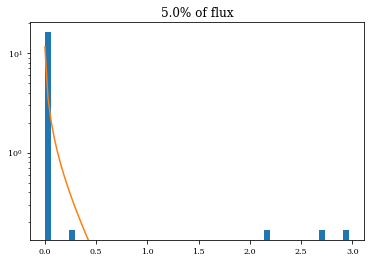

      fun: nan
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 106.6972878 ,  755.47406482, -734.42852582])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 324
      nit: 25
   status: 2
  success: False
        x: array([ 1.37723719, -0.02482884,  0.07442437])


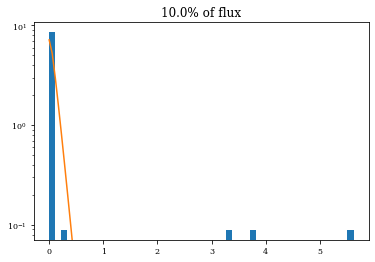

      fun: nan
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([  16.30011077,  158.3152681 , -640.14216505])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 316
      nit: 23
   status: 2
  success: False
        x: array([ 3.9853375 , -0.18196085,  0.056109  ])


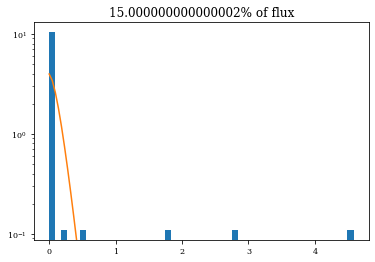

      fun: nan
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([10.12542015, 43.81731173, 73.12598456])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 224
      nit: 13
   status: 2
  success: False
        x: array([ 6.10575104, -0.86951474,  0.16737483])


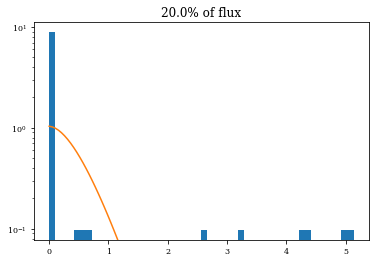

      fun: nan
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([  106.79495404, -1037.44469158, -1352.75073205])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 296
      nit: 24
   status: 2
  success: False
        x: array([ 0.91140832, -0.01      ,  0.06914475])


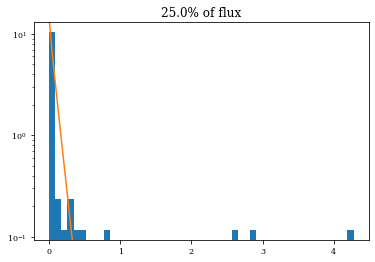

      fun: nan
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([   66.51925446,   402.71252146, -3472.00771387])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 312
      nit: 16
   status: 2
  success: False
        x: array([ 1.31254757, -0.01      ,  0.01967452])


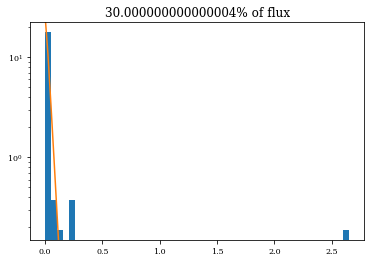

      fun: nan
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([16.8288075 , 18.49548497, 84.69707282])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 532
      nit: 36
   status: 2
  success: False
        x: array([ 2.95575111, -0.64357785,  0.29590903])


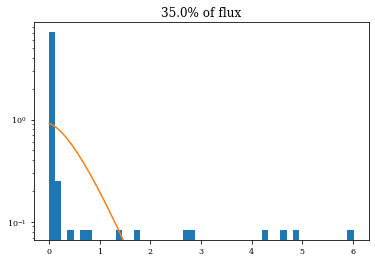

      fun: nan
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 34.74599666, 112.27998868,  53.46704626])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 736
      nit: 51
   status: 2
  success: False
        x: array([ 2.25253575, -0.17641894,  0.12398641])


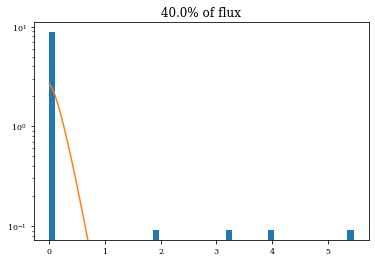

      fun: nan
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([   36.32694927, -3898.68450696, -2232.29783671])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 288
      nit: 21
   status: 2
  success: False
        x: array([ 0.55399431, -0.01      ,  0.06721889])


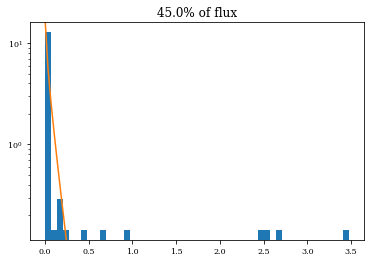

      fun: nan
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 36.09364398, 538.93152483,  94.93543871])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 260
      nit: 12
   status: 2
  success: False
        x: array([ 3.14555186, -0.09343183,  0.04583918])


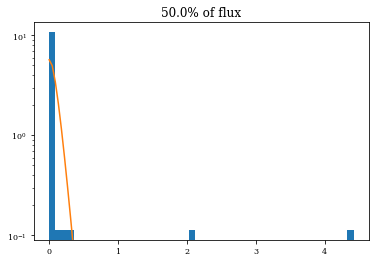

In [7]:
scales = sorted([float(x) for x in all_res.keys()])

for scale in scales:

    for key, val in all_res[scale].items():

        gd = GammaDistribution(val)

        data = np.array(val)

    #     bins = np.histogram(data, bins=20)
    #     print(np.log(bins[0]), len(bins[0]), len(bins[1]))

    #     x_vals = [np.mean([x + bins[1][i+1]]) for i, x in enumerate(bins[1][:-1])]

    #     plt.plot(x_vals, np.log(bins[0]))

    #     print(x_vals, np.log(bins[0]))

        weights = np.ones(len(val))
        weights /= np.sum(weights)
        mask = data > 0.
        
        plt.figure()

        plt.hist(data, density=True, bins=50)
    #     plt.hist(data[mask], weights=weights[mask])
    #     plt.hist(data[~mask], weights=weights[~mask], color="grey")
        x_range = np.linspace(min(data), max(data), 100)
    #     plt.plot(x_range, scipy.stats.gamma.pdf(x_range, res["x"][0], loc=0., scale=res["x"][1]))
        plt.yscale("log")
        ylim = plt.gca().get_ylim()
        plt.plot(x_range, gd.dist.pdf(x_range))#*(1 - gd.frac_under_zero))
        plt.gca().set_ylim(ylim)
        plt.title("{0}% of flux".format(scale*100.))
        plt.show()
        
        if not scale > 0.:

            for i in [3, 4, 5, 6]:
                disc_threshold = gd.calculate_discovery_potential(i)
                print("{0} Sigma Discovery Potential: {1}".format(i, disc_threshold))
                print(gd.dist.cdf(disc_threshold))# + gd.frac_under_zero)

In [8]:
levels = [
    ("Background Median", sens_threshold),
    ("3 Sigma Discovery Potential", disc_3_threshold),
    ("4 Sigma Discovery Potential", disc_4_threshold),
    ("5 Sigma Discovery Potential", disc_5_threshold),
    ("6 Sigma Discovery Potential", disc_6_threshold)
]


for step, res in all_res.items():
    print("Fraction of neutrino alerts correlated to source: {0} \n".format(step))

    bkgs = dict()

    for key, val in res.items():
        print(key, np.mean(val), np.median(val), np.std(val))
        val = np.array(val)

        for name, thresh in levels:
            print(thresh[key])
            print("Fraction above {0}: {1}".format(
                name, np.sum(val > thresh[key])/float(len(val))))

Fraction of neutrino alerts correlated to source: 0.0 

average_flux_weight 0.1896310670291255 0.0 0.8380406152729619
0.0
Fraction above Background Median: 0.126
0.8747440474850754
Fraction above 3 Sigma Discovery Potential: 0.053
1.473269970888121
Fraction above 4 Sigma Discovery Potential: 0.045
2.1888651067279286
Fraction above 5 Sigma Discovery Potential: 0.041
3.0285114643841458
Fraction above 6 Sigma Discovery Potential: 0.032
Fraction of neutrino alerts correlated to source: 0.05 

average_flux_weight 0.08122993971008803 0.0 0.44836773393125673
0.0
Fraction above Background Median: 0.1
0.8747440474850754
Fraction above 3 Sigma Discovery Potential: 0.03
1.473269970888121
Fraction above 4 Sigma Discovery Potential: 0.03
2.1888651067279286
Fraction above 5 Sigma Discovery Potential: 0.02
3.0285114643841458
Fraction above 6 Sigma Discovery Potential: 0.0
Fraction of neutrino alerts correlated to source: 0.1 

average_flux_weight 0.13038716029402014 0.0 0.7439874173698151
0.0
Fractio

In [9]:
# for key, val in all_res[zero_key].items():
#     weights = np.ones_like(val)/float(len(val))
#     plt.hist(val, weights=weights, bins=50)
#     plt.title(key)
#     plt.yscale("log")
#     plt.figure()
#     plt.hist(val, weights=weights, cumulative=True, bins=50)

In [10]:
# import numpy as np
# res = np.arccos(np.random.uniform(size=1000)*2 - 1) - np.pi/2.
# plt.hist(res)
# plt.hist(np.cos(np.pi/2. - res))